In [89]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_svmlight_file
import numpy as np
import pickle
import glob
import os

from matplotlib.ticker import MaxNLocator

from utils import unpickle_dir

LOG_SCALE = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# epsilon

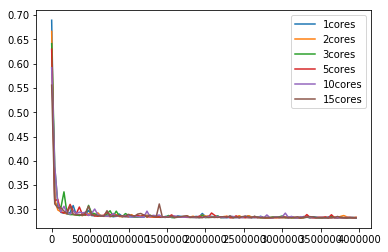

In [90]:
DIR = "/mlodata1/jb/sparsifiedSGD-results/epsilon-par/"
runs = list(glob.glob(os.path.join(DIR, "*")))

data = dict([(p.split('/')[-1], unpickle_dir(p)) for p in runs])


for i in [1,2,3,5,10,15]:
    datum = data['top10-cores{}-0'.format(i)]
    plt.plot(datum['iters'], datum['losses'], label="{}cores".format(i))


plt.legend()
    

In [91]:
data.keys()



dict_keys(['rand10-cores22-0', 'top10-cores2-0', 'sgd-cores40-2', 'top10-cores18-0', 'rand10-cores25-1', 'top10-cores22-0', 'top10-cores3-2', 'rand10-cores5-0', 'rand10-cores35-1', 'rand10-cores30-2', 'top10-cores5-0', 'rand10-cores8-2', 'top10-cores20-0', 'rand10-cores2-0', 'sgd-cores5-0', 'sgd-cores2-1', 'sgd-cores20-1', 'sgd-cores3-1', 'rand10-cores18-2', 'sgd-cores20-2', 'sgd-cores25-0', 'rand10-cores5-2', 'sgd-cores44-0', 'rand10-cores20-0', 'sgd-cores2-0', 'sgd-cores35-2', 'rand10-cores48-2', 'rand10-cores32-1', 'top10-cores10-0', 'sgd-cores5-2', 'rand10-cores35-0', 'sgd-cores48-0', 'rand10-cores40-1', 'top10-cores35-2', 'sgd-cores1-2', 'sgd-cores22-1', 'sgd-cores30-0', 'sgd-cores40-0', 'rand10-cores20-2', 'top10-cores18-1', 'sgd-cores1-1', 'top10-cores32-2', 'top10-cores48-2', 'top10-cores18-2', 'top10-cores40-1', 'rand10-cores48-1', 'sgd-cores40-1', 'top10-cores40-0', 'sgd-cores8-2', 'sgd-cores18-0', 'top10-cores15-1', 'top10-cores35-0', 'rand10-cores44-0', 'top10-cores1-0', 't

models: ['sgd', 'rand10', 'top10']
[1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 22, 25, 30, 32, 35, 40, 44, 48]
stopping threshold 0.28267376250519427


Text(0, 0.5, 'relative speed up to converge')

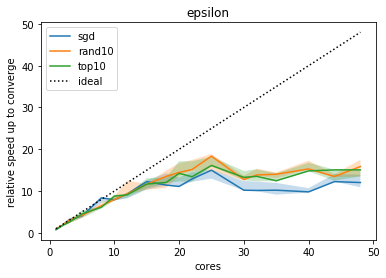

In [92]:
# put into one array (model, cores, timeserie)
models = list(set([k.split('-')[0] for k in data.keys()]))
print('models:', models)
# models = ['rand10', 'top10', 'sgd']
# cores = [1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 22, 25,]
cores = sorted(list(set([int(k.split('-')[1][len('cores'):]) for k in data.keys()])))
print(cores)
repeat = 3
shape = [len(models), len(cores), repeat, len(data['rand10-cores1-0']['timers'])]
iters = np.zeros(shape)
losses = np.zeros(shape)
timers = np.zeros(shape)

for i, model in enumerate(models):
    for j, core in enumerate(cores):
        for k in range(repeat):
            name = "{}-cores{}-{}".format(model, core, k)
            datum = data[name]  # iters, loss, timers
            iters[i, j, k, :] = datum['iters']
            losses[i, j, k, :] = datum['losses']
            timers[i, j, k, :] = datum['timers']

threshold = losses.min(axis=-1).max()
print('stopping threshold', threshold)
stop_iter = (losses <= threshold).argmax(axis=-1)
chronos = np.zeros(stop_iter.shape)
for i in range(len(models)):
    for j in range(len(cores)):
        for k in range(repeat):
            chronos[i,j,k] = timers[i,j,k,stop_iter[i, j, k]]

chronos_sorted = np.sort(chronos, axis=-1)
speedup = chronos_sorted[:, 0, 0, np.newaxis, np.newaxis] / chronos_sorted
for i, model in enumerate(models):
    c = "C{}".format(i)
    plt.plot(cores, speedup[i, :, 1], c=c, label=model)
    plt.fill_between(cores, speedup[i, :, 0], speedup[i, :, 2], facecolor=c, alpha=0.25)



lim = [min(cores), max(cores)]
plt.plot(lim, lim, linestyle=':', color="black", label="ideal")
plt.legend()
plt.title('epsilon')
plt.xlabel('cores')
plt.ylabel('relative speed up to converge')

# RCV

[]

Text(0.5, 1.0, 'RCV1')

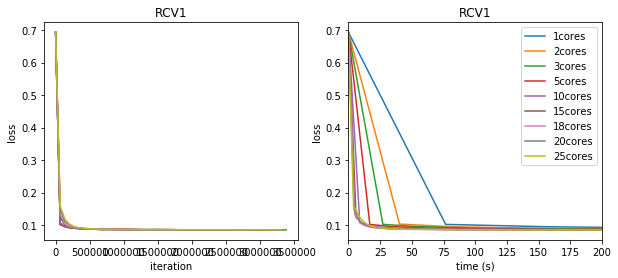

In [106]:
pattern = "/mlodata1/jb/sparsifiedSGD-results/rcv1-par86/*-0"
runs = list(glob.glob(pattern))

data = dict([(p.split('/')[-1], unpickle_dir(p)) for p in runs])
fix, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

for i in [1,2,3,5,10,15, 18, 20, 25]:
    datum = data['top50-cores{}-0'.format(i)]
    ax1.plot(datum['iters'], datum['losses'], label="{}cores".format(i))
    ax2.plot(datum['timers'], datum['losses'], label="{}cores".format(i))


plt.legend()

ax1.set_xlabel('iteration')
ax1.set_ylabel('loss')
ax1.set_title('RCV1')

ax2.set_xlabel('time (s)')
ax2.set_ylabel('loss')
ax2.set_xlim([0,200])
ax2.set_title('RCV1')
    

In [107]:
data.keys()

dict_keys(['sgd-cores3-0', 'rand50-cores3-0', 'rand50-cores25-0', 'top50-cores2-0', 'rand50-cores2-0', 'sgd-cores5-0', 'sgd-cores2-0', 'sgd-cores10-0', 'rand50-cores18-0', 'top50-cores20-0', 'rand50-cores1-0', 'sgd-cores18-0', 'top50-cores12-0', 'top50-cores15-0', 'top50-cores25-0', 'rand50-cores10-0', 'rand50-cores5-0', 'rand50-cores15-0', 'sgd-cores8-0', 'sgd-cores12-0', 'top50-cores10-0', 'top50-cores3-0', 'sgd-cores25-0', 'sgd-cores15-0', 'rand50-cores20-0', 'sgd-cores1-0', 'top50-cores8-0', 'sgd-cores20-0', 'top50-cores1-0', 'rand50-cores12-0', 'rand50-cores8-0', 'top50-cores18-0', 'top50-cores5-0'])

models: ['sgd', 'top50', 'rand50']
cores: [1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 25]
stopping threshold 0.08498480441951108


Text(0, 0.5, 'relative speed up to converge')

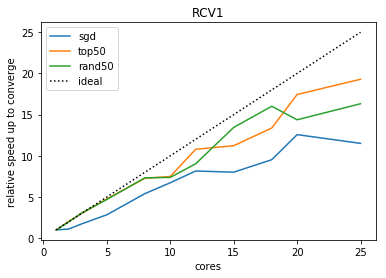

In [108]:
# put into one array (model, cores, timeserie)

models = list(set([k.split('-')[0] for k in data.keys()]))
print('models:', models)
cores = sorted(list(set([int(k.split('-')[1][len('cores'):]) for k in data.keys()])))
print('cores:', cores)

# models = ['rand10', 'top10', 'sgd']
# cores = [1, 2, 3, 5, 10, 15, 18, 20, 25]
repeat = 1
length = len(data['{}-cores{}-0'.format(models[0], cores[0])]['timers'])
shape = [len(models), len(cores), repeat, length]
iters = np.zeros(shape)
losses = np.zeros(shape)
timers = np.zeros(shape)

for i, model in enumerate(models):
    for j, core in enumerate(cores):
        for k in range(repeat):
            name = "{}-cores{}-{}".format(model, core, k)
            datum = data[name]  # iters, loss, timers
            iters[i, j, k, :] = datum['iters'][:length]
            losses[i, j, k, :] = datum['losses'][:length]
            timers[i, j, k, :] = datum['timers'][:length]

threshold = losses.min(axis=-1).max()
print('stopping threshold', threshold)
stop_iter = (losses <= threshold).argmax(axis=-1)
chronos = np.zeros(stop_iter.shape)
for i in range(len(models)):
    for j in range(len(cores)):
        for k in range(repeat):
            chronos[i,j,k] = timers[i,j,k,stop_iter[i, j, k]]

chronos_sorted = np.sort(chronos, axis=-1)
speedup = chronos_sorted[:, 0, 0, np.newaxis, np.newaxis] / chronos_sorted
for i, model in enumerate(models):
    c = "C{}".format(i)
    plt.plot(cores, speedup[i, :, 0], c=c, label=model)
#     plt.fill_between(cores, speedup[i, :, 0], speedup[i, :, 2], facecolor=c, alpha=0.25)



lim = [min(cores), max(cores)]
plt.plot(lim, lim, linestyle=':', color="black", label="ideal")
plt.legend()
plt.title('RCV1')
plt.xlabel('cores')
plt.ylabel('relative speed up to converge')

In [57]:
stop_iter

array([[[20],
        [19],
        [26],
        [26],
        [29],
        [40],
        [38],
        [46],
        [49]],

       [[20],
        [19],
        [20],
        [26],
        [30],
        [31],
        [38],
        [41],
        [49]],

       [[19],
        [20],
        [20],
        [20],
        [25],
        [27],
        [20],
        [20],
        [20]]])